<h1>Structural Time Series Model with Intervention with Time Varying Coefficient Data Simulation</h1>
<h4>x_t is sine function</h4>

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline



In [2]:
# Construct the model
class localtrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, x_t):
        k_posdef = 3
        exog = x_t
        # Initialize the state space model
        super(localtrend, self).__init__(endog, exog = exog, k_states=3, k_posdef=3,
                                  initialization='approximate_diffuse',
                                        loglikelihood_burn=2)
        
        xt = exog[np.newaxis, np.newaxis, :]
        zero = np.zeros([1,1,len(exog)])
        one = np.ones([1,1,len(exog)])
        con_design = np.concatenate((one,zero,xt), axis = 1)

        # Setup the fixed components of the state space representation
        self['design'] = con_design
        self['transition'] = np.eye(self.k_states)
        self['transition', 0, 1] = 1
        self['selection'] = np.eye(self.k_states,k_posdef)
        
        self.positive_parameters = slice(0,4)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(localtrend, self).update(params, transformed, **kwargs)
        
        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]
        self['state_cov', 1, 1] = params[2]
        self['state_cov', 2, 2] = params[3]
        

    @property
    def start_params(self):
        return np.r_[[np.std(self.endog)]*3, 1]
    
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

<li>Local Linear Trend Model<ol>
    <li>Sigma: variance of noise</li>
    <li>Epsilon: disturbance</li>
    <li>Zeta and xi: error </li>
    </ol>
</li>
<br>
    
\begin{equation*}
y_{t} = {\mu}_t + \epsilon_t + \beta_t x_t \quad\epsilon_t \sim N(0,\sigma_{\epsilon}^2)\\
\mu_{t+1} = {\mu}_t + v_t +\xi_t \quad\xi_t \sim N(0,\sigma_{\xi}^2)\\
v_{t+1} = v_t + \zeta_t \quad\zeta_t \sim N(0,\sigma_{\zeta}^2) \\
\beta_{t+1} = \beta_t + \omega_t \quad\omega_t \sim N(0,\sigma_{\omega}^2)
\end{equation*}

State Space Representation:
\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 & x_t
\end{vmatrix} \begin{pmatrix}
\mu_t \\
v_t \\
\beta_t
\end{pmatrix} + \epsilon_t\\
\begin{pmatrix}
\mu_t \\
v_t \\
\beta_t
\end{pmatrix}= \begin{vmatrix}
1 & 1 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{vmatrix} \begin{pmatrix}
\mu_t \\
v_t \\
\beta_t
\end{pmatrix} + \begin{pmatrix}
\xi_t \\
\zeta_t \\
\omega_t
\end{pmatrix}
\end{equation*}


In [3]:
# True model parameters
nobs = int(1e4)
true_epsilon = 4
true_zeta = 2
true_xi = 9
#x_var = 16
#true_beta = 2
true_omega = 0.64



In [4]:
# Simulate a time series
np.random.seed(1234)
disturbances_xi = np.random.normal(0, math.sqrt(true_xi), size=(nobs,))
vt = lfilter([1], np.r_[1, -1], disturbances_xi)
disturbances_zeta = np.random.normal(0, math.sqrt(true_zeta), size=(nobs,))
vt_d = vt + disturbances_zeta
mut = lfilter([1], np.r_[1, -1], vt_d)
disturbances_epsilon = np.random.normal(0, math.sqrt(true_epsilon), size=(nobs,))
#x_t = np.random.normal(3, math.sqrt(x_var), size=(nobs,))
x_t = np.random.random_sample(nobs)*5

#cycle = [np.linspace(-np.pi, np.pi-np.pi/25, 50)] * 200
#x_t_ang = np.reshape(np.array(cycle), 10000)
#x_t = np.sin(x_t_ang)

beta = np.random.normal(0, math.sqrt(true_omega), size=(nobs,))
intervention = x_t*beta
yt = mut + disturbances_epsilon + intervention


In [5]:
mod = localtrend(yt, x_t)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                     localtrend   Log Likelihood              -30887.823
Date:                Mon, 13 Feb 2023   AIC                          61783.645
Time:                        10:49:29   BIC                          61812.486
Sample:                             0   HQIC                         61793.408
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        4.2558      0.285     14.954      0.000       3.698       4.814
param.1        1.8427      0.842      2.189      0.029       0.193       3.492
param.2        9.1548      0.343     26.688      0.0

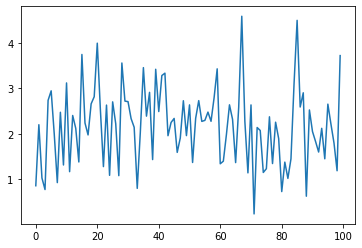

In [82]:
plt.plot(beta[:100])

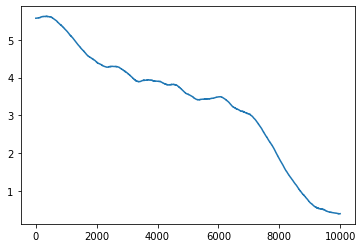

In [83]:
plt.plot(res.smoothed_state[2])

In [ ]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [91]:
mod = LocalLinearTrend(yt)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48342D+00    |proj g|=  5.67765D-04
  ys=-3.012E-01  -gs= 1.565E-01 BFGS update SKIPPED


 This problem is unconstrained.



At iterate    5    f=  6.21010D+00    |proj g|=  4.07811D-03

At iterate   10    f=  3.43768D+00    |proj g|=  3.09306D-01

At iterate   15    f=  3.13020D+00    |proj g|=  5.91948D-03

At iterate   20    f=  3.12672D+00    |proj g|=  1.39123D-03

At iterate   25    f=  3.12672D+00    |proj g|=  1.13442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     67      1     1     0   7.437D-07   3.127D+00
  F =   3.1267152983234783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                    